In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import random

## Defining useful functions

In [2]:
#Function to change multiclass classification to 1 vs all
def multiclass_to_binary(labels, most_common_id):
    to_binary = lambda val: 1 if val == most_common_id else 0
    to_binary_vec = np.vectorize(to_binary)

    labels_1vsall = to_binary_vec(labels)

    return labels_1vsall

## Pulling Full Sample Dataset from CSV and convert to np array

In [3]:
import os
path = os.getcwd()
par = os.path.abspath(os.path.join(path, os.pardir))

data_path = os.path.join(par,'3_generate_features','final_feature_array.csv')
label_path = os.path.join(par,'3_generate_features','final_label_array.csv')

os.path.isfile(data_path)


True

In [49]:
pd.set_option('display.max_columns', None)

In [30]:
#Turn into DF
prototype_df = pd.read_csv(data_path)
label_df = pd.read_csv(label_path)

#Drop formula column
prototype_df = prototype_df.drop(columns=['Formula','Collection_Code'])
prototype_df.head()

,e1_Number,e1_MendeleevNumber,e1_AtomicWeight,e1_MeltingT,e1_Column,e1_Row,e1_CovalentRadius,e1_Electronegativity,e1_NsValence,e1_NpValence,...,e2_NValence,e2_NsUnfilled,e2_NpUnfilled,e2_NdUnfilled,e2_NfUnfilled,e2_NUnfilled,e2_GSvolume_pa,e2_GSbandgap,e2_GSmagmom,e2_SpaceGroupNumber
0,22.0,43.0,47.867000,1941.0,4.0,4.0,160.0,1.54,2.0,0.0,...,4.0,0.0,0.0,8.0,0.0,8.0,16.690000,0.000,0.000023,194.0
1,14.0,78.0,28.085500,1687.0,14.0,3.0,111.0,1.90,2.0,2.0,...,4.0,0.0,4.0,0.0,0.0,4.0,20.440000,0.773,0.000000,227.0
2,25.0,52.0,54.938045,1519.0,7.0,4.0,139.0,1.55,2.0,0.0,...,7.0,0.0,0.0,5.0,0.0,5.0,10.487586,0.000,0.000310,217.0
3,12.0,68.0,24.305000,923.0,2.0,3.0,141.0,1.31,2.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,22.890000,0.000,0.000000,194.0
4,14.0,78.0,28.085500,1687.0,14.0,3.0,111.0,1.90,2.0,2.0,...,4.0,0.0,4.0,0.0,0.0,4.0,20.440000,0.773,0.000000,227.0


In [31]:
#Dataframe convert label into categorical variable for classification
#Then convert labels into numpy array
label_name = 'Prototype'
label_df[label_name]= pd.Categorical(label_df[label_name])
label_df['numeric_label'] = label_df[label_name].cat.codes

#Convert numerical dataframe column to array
labels = label_df['numeric_label'].to_numpy()

label_df.head()


,Prototype,numeric_label
0,Anatase#TiO2,18
1,Cristobalite#SiO2,114
2,Rutile#TiO2,298
3,Laves(2H)#MgZn2,201
4,Quartz(low)#SiO2,287


## Cleaning Low class representations since TSNE and PCA is not well separated

In [76]:
#Find class frequencies
#Inner expression label_df[]...index.tolist or ...values.tolist converts the value_counts index to both the index identifier as well as its value
#The index identifier is the label 
label_names_sorted = np.array(label_df['numeric_label'].value_counts().index.tolist())
label_values_sorted = np.array(label_df['numeric_label'].value_counts().values.tolist())

#Create overall labels array for ease of indexing
labels_array = np.transpose(np.stack([label_names_sorted, label_values_sorted]))

#See pandas categorical mapping to numbers
label_dict = dict(enumerate(label_df['Prototype'].cat.categories))



array([[ 203, 1532],
       [ 151,  507],
       [ 201,  475],
       [ 298,  467],
       [  13,  368],
       [ 285,  250],
       [ 124,  237],
       [  67,  203],
       [  45,  182],
       [ 211,  169],
       [ 287,  144],
       [  14,  139],
       [  96,  134],
       [ 268,  127],
       [ 358,  126],
       [ 220,  111],
       [  49,  105],
       [ 103,   93],
       [ 282,   82],
       [ 366,   75],
       [  30,   73],
       [ 417,   70],
       [ 113,   69],
       [ 108,   65],
       [ 128,   60],
       [ 399,   60],
       [ 114,   55],
       [ 142,   54],
       [ 413,   51],
       [ 362,   49],
       [ 235,   49],
       [  18,   48],
       [ 120,   42],
       [  39,   41],
       [  50,   40],
       [  28,   40],
       [ 107,   39],
       [ 202,   38],
       [ 129,   38],
       [ 275,   36],
       [ 224,   35],
       [ 135,   35],
       [  58,   34],
       [ 197,   33],
       [  46,   33],
       [ 325,   32],
       [  56,   32],
       [  51,

In [102]:
#Setting up masks to trim the dataset of classes with low representation
class_nthreshold = 50
low_classes_ids = labels_array[labels_array[:,1] <= class_nthreshold,0].tolist()


#Trimming feature_df to remove all low class representations
trimmed_prototype_df = prototype_df.loc[~label_df['numeric_label'].isin(low_classes_ids)]
trimmed_labels_df = label_df[~label_df['numeric_label'].isin(low_classes_ids)]

print(f'Prototype DF length before trimming is {len(prototype_df)}')
print(f'Prototype DF length after trimming is {len(trimmed_prototype_df)}')



Prototype DF length before trimming is 8748
Prototype DF length after trimming is 6083


In [103]:
#Convert trimmed dataframes to numpy
#Also define feature names for symbolic regression

features = trimmed_prototype_df.to_numpy()
feature_names = list(trimmed_prototype_df.columns)

labels = trimmed_labels_df['numeric_label'].to_numpy()

In [104]:
#Define most class id of interesvt and relabel
id_ofinterest = 203

labels_1vsall = multiclass_to_binary(labels, most_common_id=203)

## Normalizing Dimensions for PCA


In [105]:
#Normalizing all features for PCA analysis using StandardScaler
features_scaled = StandardScaler().fit_transform(features)



In [106]:
#Principal Component Analysis
pca_features = PCA(n_components=10)
principal_features = pca_features.fit_transform(features_scaled)

print('Explained variation per principal component: {}'.format(pca_features.explained_variance_ratio_))


Explained variation per principal component: [0.34858011 0.16161539 0.13297451 0.08269772 0.0723622  0.05612398
 0.03886115 0.03044926 0.02265808 0.01305499]


In [107]:
#Assigning principal components to independent variables
PC_1 = principal_features[:,0]
PC_2 = principal_features[:,1]


In [109]:
def plot_embedding(embedded_data, labels, mode='PCA'):

    plt.figure(figsize=(10,10))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    plt.xlabel('PC1', fontsize = 20)
    plt.ylabel('PC2', fontsize = 20)
    plt.title(f'Embedding Analysis using {mode}', fontsize=20)
    target_vals = [0,1]
    colors = ['r','b']

    for target, color in zip(target_vals, colors):
        #Mask for target
        relevant_mask = labels == target
        #Finding X, Y datapoints corresponding to target mask (i.e. all PCA components from positive group)
        x_pts = embedded_data[relevant_mask,0]
        y_pts = embedded_data[relevant_mask,1]
        
        #Plot scatter
        plt.scatter(x_pts, y_pts, c = color, s = 20)

    plt.legend(target_vals, prop={'size': 15})


(6083, 10)

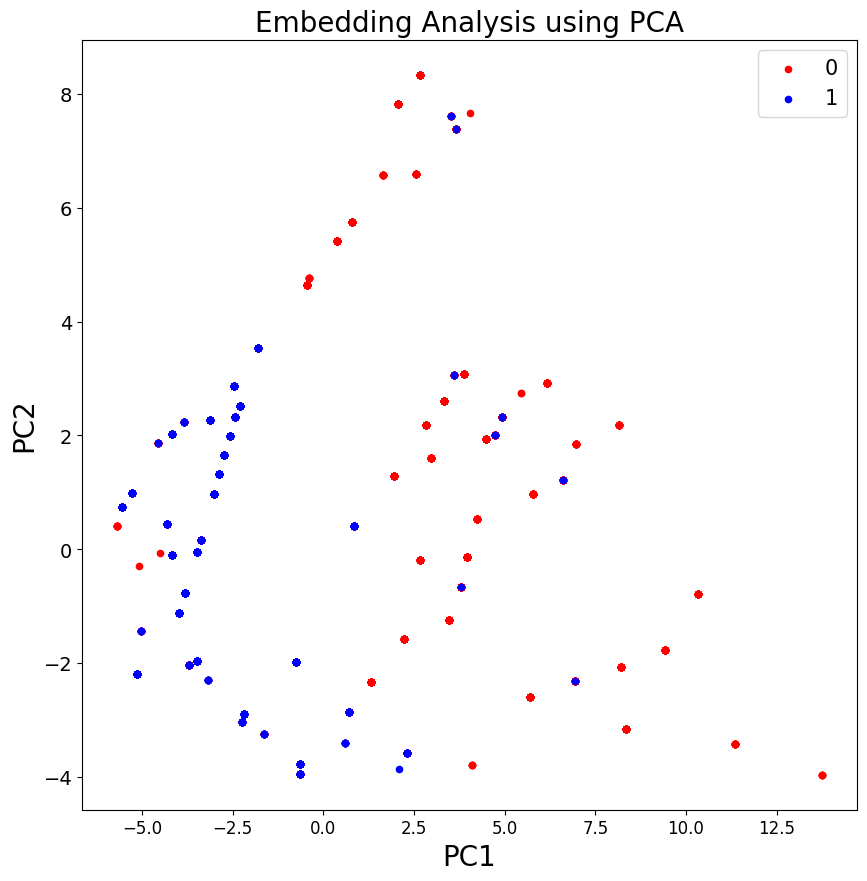

In [110]:
plot_embedding(principal_features, labels_1vsall, mode='PCA')

In [93]:
#Trying T-SNE

from sklearn.manifold import TSNE

features_embedded = TSNE(n_components = 2, learning_rate = 'auto',
                         init = 'random', perplexity = 5).fit_transform(principal_features)

features_embedded.shape



(7096, 2)

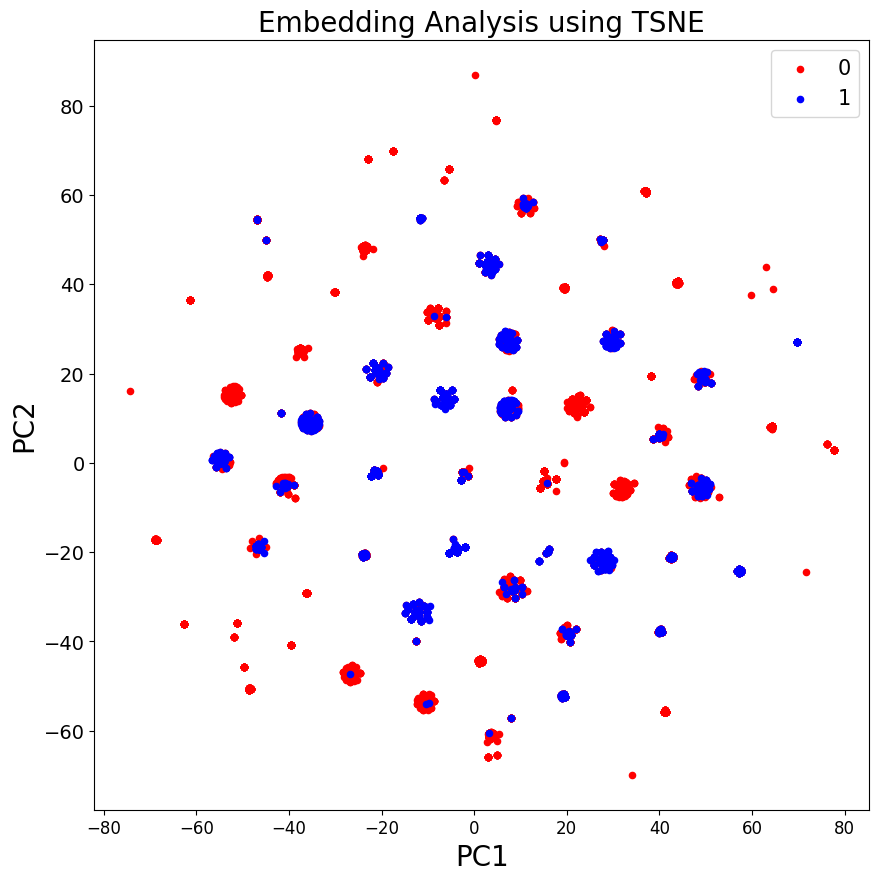

In [92]:
plot_embedding(features_embedded, labels_1vsall, mode = 'TSNE')

## UMAP Visualization

In [94]:
import umap


In [96]:
dim_reducer = umap.UMAP()

In [100]:
umap_embed = dim_reducer.fit_transform(principal_features)

umap_embed.shape

/opt/homebrew/Caskroom/miniconda/base/envs/hackathon/lib/python3.10/multiprocessing/resource_tracker.py:104: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '


(7096, 2)

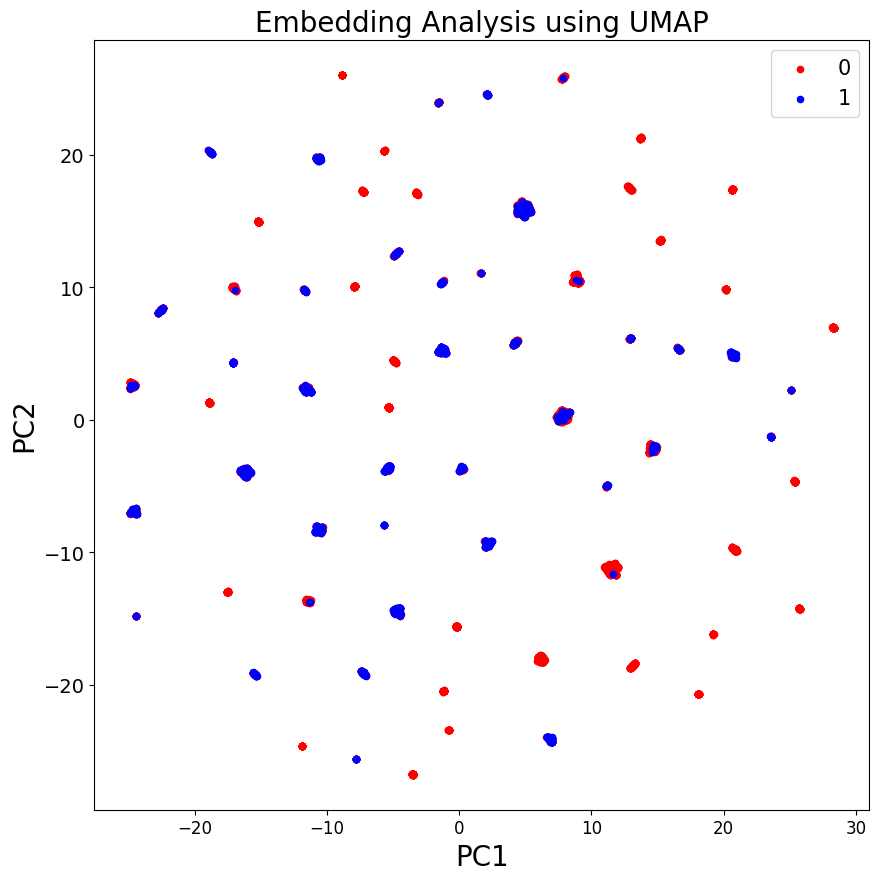

In [101]:
plot_embedding(umap_embed, labels_1vsall, mode = 'UMAP')